In [1]:
import csv
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import sklassyNN as sknn

In [2]:
repo_paths = ['/home/simonealbanesi/repos/IPAM2021_ML/', '/home/simone/repos/IPAM2021_ML/', 
             '/Users/simonealbanesi/repos/IPAM2021_ML/']
for rp in repo_paths:
    if os.path.isdir(rp):
        repo_path = rp
        break
sys.path.insert(0, repo_path+'utils/')

In [3]:
GstLAL_file = repo_path+'datasets/real_data/real_data.csv' 
GWTC_file   = repo_path+'datasets/real_data/GWTC.csv'

# Read and print GWTC data
GWTC_dict = {}
with open(GWTC_file, 'r') as infile:
    reader = csv.DictReader(infile)
    GWTC_fieldnames = reader.fieldnames
    print('-'*80)
    print(' '*37, 'GWTC', ' '*37)
    print('-'*80)
    print('  {:15}{:13s}{:13s}{:13s}{:11s}{:s}'.format('name', 'm1', 'm2', 'Mc', 'Mc*', 'chi_eff'), sep='')
    print('-'*80)
    for row in reader:
        #if '_' not in row['commonName']:
        if row['mass_1_source']!='':
            event_id = row['id']
            m1      = float(row['mass_1_source'])
            m2      = float(row['mass_2_source'])
            chi_eff = float(row['chi_eff'])
            Mc_m1m2 = (m1*m2)**(3/5)/(m1+m2)**(1/5)
            Mc      = float(row['chirp_mass_source'])
            name    = row['commonName']
            print('{:s} {:12.3f} {:12.3f} {:12.3f} {:12.3f} {:12.3f}'.format(name, m1, m2, Mc, Mc_m1m2, chi_eff))
            pars            = {}
            pars['m1']      = m1
            pars['m2']      = m2
            pars['Mc']      = Mc
            pars['chi_eff'] = chi_eff
            GWTC_dict[name] = pars 
print('\n\n')

# Read and print GstLAL data from Sushant
GstLAL_dict = {}
with open(GstLAL_file, 'r') as infile:
    reader = csv.DictReader(infile)
    GstLAL_fieldnames = reader.fieldnames
    print('-'*66)
    print(' '*29, 'GstLAL', ' '*29)
    print('-'*66)
    print('  {:15}{:13s}{:13s}{:13s}{:11s}'.format('name', 'm1', 'm2', 'chi1', 'chi2'), sep='')
    print('-'*66)
    for row in reader:
        GWTC_number = float(row['GWTC'])
        name = row['event_id']
        #if '_' not in name and GWTC_number<3:
        if GWTC_number<3:
            m1      = float(row['m1_rec'])
            m2      = float(row['m2_rec'])
            chi1    = float(row['chi1_rec'])
            chi2    = float(row['chi2_rec'])
            print('{:s} {:12.3f} {:12.3f} {:12.3f} {:12.3f} '.format(name, m1, m2, chi1, chi2))
            Mc      = (m1*m2)**(3/5)/(m1+m2)**(1/5)
            chi_eff = (chi1*m1 + chi2*m2)/(m1+m2)   
            pars            = {}
            pars['m1']      = m1
            pars['m2']      = m2
            pars['chi1']    = chi1
            pars['chi2']    = chi2
            pars['chi_eff'] = chi_eff
            pars['Mc']      = Mc
            GstLAL_dict[name] = pars

--------------------------------------------------------------------------------
                                      GWTC                                      
--------------------------------------------------------------------------------
  name           m1           m2           Mc           Mc*        chi_eff
--------------------------------------------------------------------------------
GW150914       35.600       30.600       28.600       28.716       -0.010
GW151012       23.200       13.600       15.200       15.355        0.050
GW151226       13.700        7.700        8.900        8.868        0.180
GW170104       30.800       20.000       21.400       21.507       -0.040
GW170608       11.000        7.600        7.900        7.933        0.030
GW170729       50.200       34.000       35.400       35.830        0.370
GW170809       35.000       23.800       24.900       25.033        0.080
GW170814       30.600       25.200       24.100       24.152        0.070
GW170817 

In [4]:
# Find common keys

GWTC_keys   = list(GWTC_dict.keys())
GstLAL_keys = list(GstLAL_dict.keys()) 
shared_keys = list(set(GstLAL_keys).intersection(GWTC_keys))
N           = len(shared_keys)
GstLAL_vecs = {}
GstLAL_vecs['m1']      = np.empty((N,))
GstLAL_vecs['m2']      = np.empty((N,))
GstLAL_vecs['chi_eff'] = np.empty((N,))
GWTC_vecs = {}
GWTC_vecs['m1']        = np.empty((N,))
GWTC_vecs['m2']        = np.empty((N,))
GWTC_vecs['chi_eff']   = np.empty((N,))

recovered = np.empty((N,4))

sub_keys = ['m1', 'm2', 'chi_eff']
for i in range(len(shared_keys)):
    k = shared_keys[i]
    for j in range(len(sub_keys)):
        sk = sub_keys[j]
        GstLAL_vecs[sk][i] = GstLAL_dict[k][sk]
        GWTC_vecs[sk][i]   = GWTC_dict[k][sk]
    recovered[i,:] = [GstLAL_dict[k]['m1'], GstLAL_dict[k]['m2'], GstLAL_dict[k]['chi1'], GstLAL_dict[k]['chi2']]

In [5]:
#model2load = 'sklassyNN_farcut_m1m2chi1chi2' # far_cut 1e-10
model2load = 'sklassyNN_m1m2chi1chi2'
NN = sknn.RegressionNN(model2load=model2load)
predicted = NN.compute_prediction(recovered, transform_input=True, transform_output=True, verbose=True);
NN_vecs = {}
m1   = predicted[:,0]
m2   = predicted[:,1]
chi1 = predicted[:,2]
chi2 = predicted[:,3]
NN_vecs['m1']   = m1 
NN_vecs['m2']   = m2
NN_vecs['chi_eff'] = (chi1*m1 + chi2*m2)/(m1+m2)

prediction-time:  0.003085374999999946


m1, mean-rel-diff GstLAL: 0.2298973748236465
m1, mean-rel-diff NN    : 0.2519862691068567
 
m2, mean-rel-diff GstLAL: 0.2363960831848646
m2, mean-rel-diff NN    : 0.3058768632789776
 
chi_eff, mean-abs-diff GstLAL: 0.1628306835641182
chi_eff, mean-abs-diff NN    : 0.15441207917960992
 


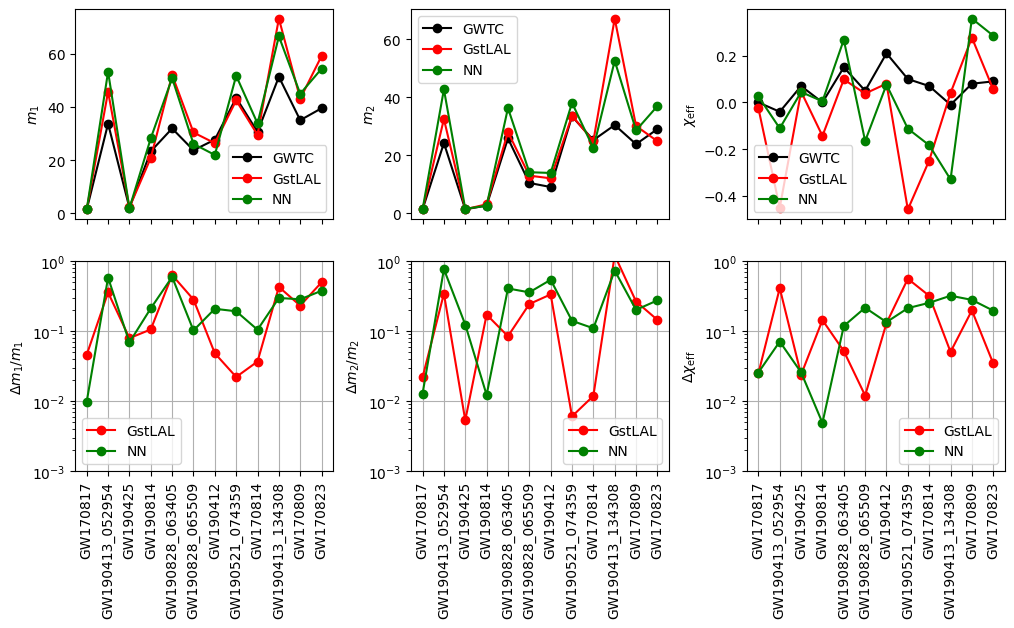

In [6]:
numbers = np.linspace(1,N,N)
plt.figure(figsize=(12,6))
tex_names = ['m_1', 'm_2', '\\chi_{\\rm eff}']
color_GstLAL = 'r'
color_NN     = 'g'
for i in range(len(sub_keys)):
    sk = sub_keys[i]
    plt.subplot(2,3,i+1)
    plt.plot(numbers, GWTC_vecs[sk], color='k', label='GWTC', marker='o')
    plt.plot(numbers, GstLAL_vecs[sk], color=color_GstLAL, label='GstLAL', marker='o')
    plt.plot(numbers, NN_vecs[sk], color=color_NN, label='NN', marker='o')
    plt.xticks(numbers, [], rotation='vertical')
    plt.ylabel('$'+tex_names[i]+'$')
    plt.legend()
    
    plt.subplot(2,3,i+4)
    abs_diff_GstLAL = np.abs(GWTC_vecs[sk]-GstLAL_vecs[sk])
    abs_diff_NN     = np.abs(GWTC_vecs[sk]-NN_vecs[sk])
    if i<2:
        rel_diff_GstLAL = abs_diff_GstLAL/GWTC_vecs[sk]
        rel_diff_NN = abs_diff_NN/GWTC_vecs[sk]
        plt.plot(numbers, rel_diff_GstLAL, color=color_GstLAL, label='GstLAL', marker='o')
        plt.plot(numbers, rel_diff_NN, color=color_NN, label='NN', marker='o')
        ylab = '$\Delta '+tex_names[i]+'/'+tex_names[i]+'$'
        print(sk,', mean-rel-diff GstLAL: ', np.mean(rel_diff_GstLAL), sep='')
        print(sk,', mean-rel-diff NN    : ', np.mean(rel_diff_NN), sep='')
    else:
        plt.plot(numbers, abs_diff_GstLAL, color=color_GstLAL, label='GstLAL', marker='o')
        plt.plot(numbers, abs_diff_NN, color=color_NN, label='NN', marker='o')
        ylab = '$\Delta '+tex_names[i]+'$'
        print(sk,', mean-abs-diff GstLAL: ', np.mean(abs_diff_GstLAL), sep='')
        print(sk,', mean-abs-diff NN    : ', np.mean(abs_diff_NN), sep='')
    plt.ylabel(ylab)
    plt.xticks(numbers, shared_keys, rotation='vertical')
    plt.yscale('log')
    plt.ylim([1e-3, 1])
    plt.grid(visible=True)
    plt.legend()
    print(' ')
    
plt.subplots_adjust(wspace=0.3)
plt.show()